In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller as adf
# import the custom functions from NN_support.py
from NN_support import sliding_window

In [2]:
# load the data from the csv file and use the date as the index
data = pd.read_csv('InvestmentReplica.csv', header=0)
data = data.set_index('Date')
data.index = pd.to_datetime(data.index, dayfirst=True)
# divide it into indexes and futures
futures_list = ['RX1','TY1','GC1','CO1','ES1','VG1',
    'NQ1','LLL1','TP1','DU1', 'TU2' ]
indexes_list = ['MXWO','MXWD','LEGATRUU','HFRXGL']
indexes = data[indexes_list]
futures = data[futures_list]

# Data exploration
## Indexes data exploration

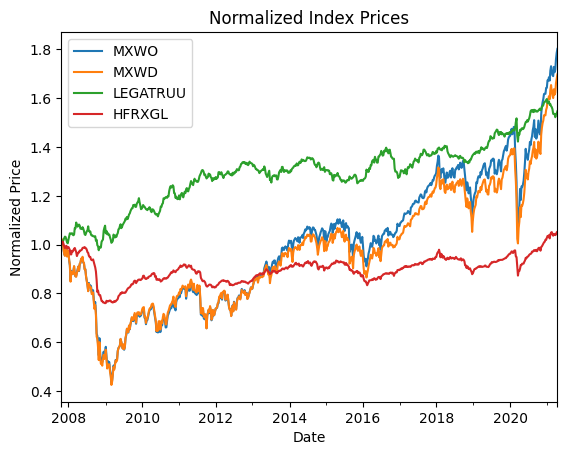

In [3]:
# plot the indexes
indexes_norm = indexes.div(indexes.iloc[0])
indexes_plot = indexes_norm.plot()
indexes_plot.set_ylabel('Normalized Price')
indexes_plot.set_xlabel('Date')
indexes_plot.set_title('Normalized Index Prices')
plt.show()

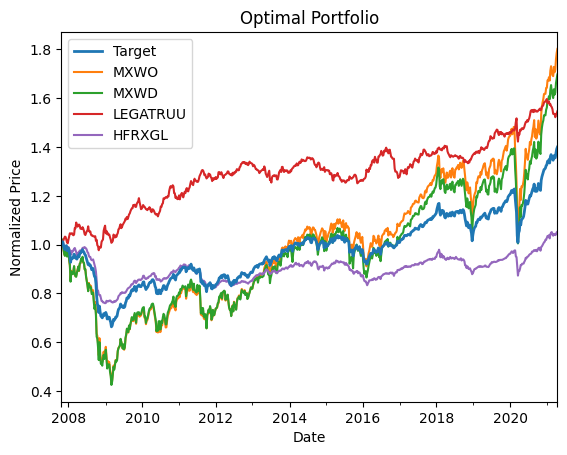

Optimal Weights:
[ 0.51298836 -0.5711139   0.43728726  0.62083829]
Expected Return:
0.0005389851958403927
Standard Deviation:
0.01099364337454438


In [4]:
# define the expected returns, their covariance matrix and the fixed return
# we want to achieve
returns = indexes.pct_change().dropna()
mu = returns.mean()
Sigma = returns.cov()
Sigma_inv = np.linalg.inv(Sigma)
r = 0.3
ones = np.ones(len(mu))

# calculate the optimal weights
w = Sigma_inv.dot(mu-r*ones)/(ones.T.dot(Sigma_inv).dot(mu-r*ones))

# define the target through the optimal weights
target = indexes.dot(w)
target.name = 'Target'

target_norm = target.div(target.iloc[0])
target_plot = target_norm.plot(zorder=1, lw=2)
indexes_norm.plot(ax=target_plot, zorder=0)
target_plot.set_ylabel('Normalized Price')
target_plot.set_xlabel('Date')
target_plot.set_title('Optimal Portfolio')
target_plot.legend(loc='best')
plt.show()

# print the optimal weights and the expected return
print('Optimal Weights:')
print(w)
print('Expected Return:')
print(target.pct_change().mean())
print('Standard Deviation:')
print(target.pct_change().std())

## Futures data exploration

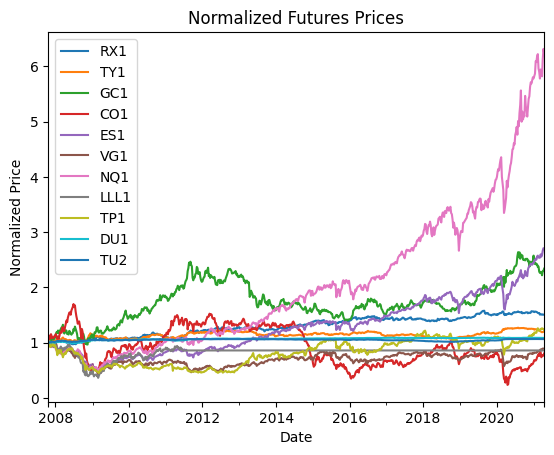

In [5]:
# graph the futures normalized prices
futures_norm = futures.div(futures.iloc[0])
futures_plot = futures_norm.plot()
futures_plot.set_ylabel('Normalized Price')
futures_plot.set_xlabel('Date')
futures_plot.set_title('Normalized Futures Prices')
plt.show()

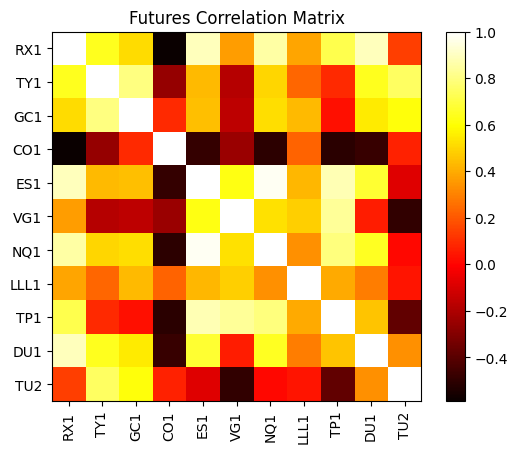

In [6]:
# create the correlation matrix heatmap
futures_corr = futures_norm.corr()
futures_corr_plot = plt.imshow(futures_corr, cmap='hot',
    interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(futures_corr)), futures_corr.columns, rotation=90)
plt.yticks(range(len(futures_corr)), futures_corr.columns)
plt.title('Futures Correlation Matrix')
plt.show()

# Stationarity test
## Original target data

In [7]:
# perform the adf test on the target data
adf_result = adf(target)
print(f""" -- ADF Test --
ADF Statistic: {adf_result[0]}
p-value: {adf_result[1]}
Critical Values:
    1%: {adf_result[4]['1%']}
    5%: {adf_result[4]['5%']}
    10%: {adf_result[4]['10%']}
{ ' The time series is Stationary' if adf_result[0] < adf_result[4]['5%']
    else 'The time series is not Stationary'}
(with 95% confidence)
""")

 -- ADF Test --
ADF Statistic: 0.6445228965397661
p-value: 0.9886631474209259
Critical Values:
    1%: -3.4396861854831964
    5%: -2.865660062273053
    10%: -2.5689640195342456
The time series is not Stationary
(with 95% confidence)



## Returns of the target

In [8]:
# get the returns of the target
target_returns = target.pct_change().dropna()

# perform the adf test on the returns of the target
adf_result = adf(target_returns)
print(f""" -- ADF Test --
ADF Statistic: {adf_result[0]}
p-value: {adf_result[1]}
Critical Values:
    1%: {adf_result[4]['1%']}
    5%: {adf_result[4]['5%']}
    10%: {adf_result[4]['10%']}
{ ' The time series is Stationary' if adf_result[0] < adf_result[4]['5%']
    else 'The time series is not Stationary'}
(with 95% confidence)
""")

 -- ADF Test --
ADF Statistic: -22.65717720414432
p-value: 0.0
Critical Values:
    1%: -3.4396861854831964
    5%: -2.865660062273053
    10%: -2.5689640195342456
 The time series is Stationary
(with 95% confidence)



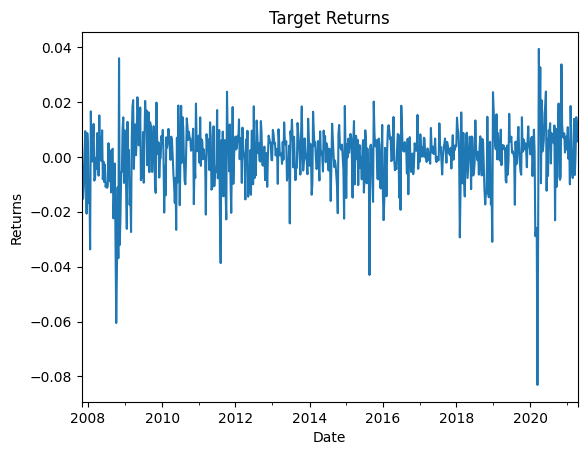

In [9]:
# graph the target returns
target_returns_plot = target_returns.plot()
target_returns_plot.set_ylabel('Returns')
target_returns_plot.set_xlabel('Date')
target_returns_plot.set_title('Target Returns')
plt.show()

## Original futures data

In [10]:
# perform the adf test on the futures data
for future in futures:
    adf_result = adf(futures[future])
    print(
        f"{future:>4} -- {adf_result[0]:>5.2f}, {adf_result[1]:.2f} -- " \
        f"""{
            'Stationary' if adf_result[0] < adf_result[4]['5%']
            else 'Not Stationary'
        }"""
    )

 RX1 -- -1.26, 0.65 -- Not Stationary
 TY1 -- -2.66, 0.08 -- Not Stationary
 GC1 -- -1.60, 0.48 -- Not Stationary
 CO1 -- -2.47, 0.12 -- Not Stationary
 ES1 --  2.06, 1.00 -- Not Stationary
 VG1 -- -2.95, 0.04 -- Stationary
 NQ1 --  3.66, 1.00 -- Not Stationary
LLL1 -- -3.40, 0.01 -- Stationary
 TP1 -- -0.99, 0.76 -- Not Stationary
 DU1 -- -2.28, 0.18 -- Not Stationary
 TU2 -- -1.94, 0.32 -- Not Stationary


## Returns of the futures

In [11]:
# get the returns of the futures
futures_returns = futures.pct_change().dropna()

# perform the adf test on the returns of the futures
for future in futures_returns:
    adf_result = adf(futures_returns[future])
    print(
        f"{future:>4} -- {adf_result[0]:>6.2f}, {adf_result[1]:.2f} -- " \
        f"""{
            'Stationary' if adf_result[0] < adf_result[4]['5%']
            else 'Not Stationary'
        }"""
    )

 RX1 -- -20.92, 0.00 -- Stationary
 TY1 -- -27.29, 0.00 -- Stationary
 GC1 -- -28.04, 0.00 -- Stationary
 CO1 --  -8.95, 0.00 -- Stationary
 ES1 -- -19.58, 0.00 -- Stationary
 VG1 -- -20.43, 0.00 -- Stationary
 NQ1 -- -26.80, 0.00 -- Stationary
LLL1 --  -4.27, 0.00 -- Stationary
 TP1 -- -29.07, 0.00 -- Stationary
 DU1 --  -6.70, 0.00 -- Stationary
 TU2 --  -6.58, 0.00 -- Stationary


# Neural network design

We want our neural network to take in input a time series of futures prices and
output a time series of weights such that the returns of the target portfolio
are replicated as closely as possible. 
We will use a feedforward neural network with 3 hidden layers.

The weights of the neural network must have the same dimensions as the matrix
of futures prices. 

In [12]:
# create the training and testing sizes
train_size = int(len(target)*0.8)
test_size = len(target) - train_size
window_size = 30

In [17]:
# create the training and testing data
target_train, futures_train = sliding_window(
    target = target,
    features = futures,
    window_size = window_size,
    end = train_size
)

target_test, futures_test = sliding_window(
    target = target,
    features = futures,
    window_size = window_size,
    start = train_size
)